<a href="https://colab.research.google.com/github/alejandromanas/GoogleColab_public/blob/master/bookings/code/bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you begin, I recommend you open this notebook with Google colab. You will be able to run the python code without having a powerful computer and to move through different sections of the document quickly

# **Booking cancellation prediction**

Booking cancellations generates a big impact on transport and hotel industries and contributes negatively to the generation of accurate forecasts. Cancellation rate can range from 20% to 60% depending on the hotel type and location. A good predictive model of cancellation could reduces losses ensuring better decision-making in the following areas:

* Booking management- Get a better forecast of net demand (bookings - cancellations)

* Revenue Management- Improve the data from which the pricing policy is set

* Resource management- Optimize the planning of purchases, services of external suppliers and staff organization. 

* Overbooking policies- Reduce the additional costs of acomodate guests in other hotels and the loss of confidence and bad publicity (bad reviews) that it can cause.

### Libraries & basic functions

In [0]:
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import KFold
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

# Time execution mesure
def tic():
  global _start_time 
  _start_time = time.time()

def tac():
  t_sec = round(time.time() - _start_time)
  (t_min, t_sec) = divmod(t_sec,60)
  (t_hour,t_min) = divmod(t_min,60) 
  time_elapsed=print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

The purpose of this notebook is to show several supervised clasification models that allows to predict if a hotel booking will be canceled in the future. 

The algorithms used are: 
* Logistic regression
* SVM (Support Vector Machine)
* XGBoost
* LightGBM 
* Neural network



### Loading Data

The data used in the analysis was obtained from an article entitled "Hotel booking demand datasets"  and written by Nuno Antonio, Anade Almeid and Luis Nunes (https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The article includes a dataset with 120,000 reservations from two hotels of one of the major portuguese hotels brand. Both hotels have more than 200 rooms and a four stars rating. One is a city hotel located in Lisbon and the other is a resort hotel in the Algarve. The reservations have an arrival date between 1st July 2015 and 31th August 2017. 

Each reservation includes about 31 variables or columns. Some of them are:
* Booking status (cancelled or not cancelled)
* Lead time
* Number of nights (weekdays and weekends)
* Average price per night
* Distribution channel
* Market segment
* Room type
* Number of guests (babes, childs or adults)

In [1]:
#Importing data from public github repository 

import pandas as pd

H1 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H1.csv", delimiter = ',')
H1['Hotel']='Resort'

#outcome 'IsCancelled'
H2 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H2.csv", delimiter = ',')
H2['Hotel']='Urban'

df_raw=[]
df_data=[]
df_raw=pd.concat([H1,H2], axis=0,ignore_index=True)

df_raw.head(5)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,Resort
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,Resort
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,Resort
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,Resort
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,Resort


### Data Analysis

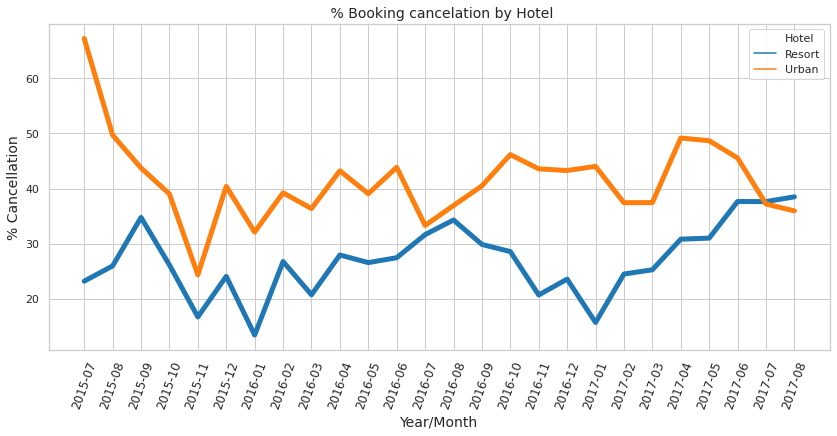

In [4]:
#Libraries
import matplotlib.pyplot as plt

df_analysis = df_raw.copy()
df_analysis.columns
df_analysis['ArrivalDateMonthNum']=df_analysis.ArrivalDateMonth.replace({ 'January' : '01', 'February' : '02', 'March' : '03', 'April' :'04', 'May': '05', 'June' : '06', 'July':'07', 'August' : '08', 'September' : '09', 'October' : '10', 'November': '11', 'December' : '12' })
df_analysis['ArrivalDateYearMonth'] = df_analysis['ArrivalDateYear'].astype('str')+'-'+ df_analysis['ArrivalDateMonthNum'].astype('str')

# GROUP BY
col_name= 'ArrivalDateYearMonth'
df=(df_analysis.groupby(['Hotel',col_name]).sum()['IsCanceled']/df_analysis.groupby(['Hotel',col_name]).count()['IsCanceled'] *100).to_frame()
df.reset_index(inplace=True)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x="ArrivalDateYearMonth", y="IsCanceled", hue="Hotel", data=df,linewidth=5,palette="tab10")
ax.set_title(' % Booking cancelation by Hotel',fontsize=14)
ax.set_xlabel('Year/Month',fontsize=14);
ax.set_ylabel('% Cancellation',fontsize=14);
ax.set_xticklabels(labels=df.ArrivalDateYearMonth,rotation=70,size=12);
plt.show()

Agent

values count
          9    31961
       NULL    16340
        240    13922
          1     7191
         14     3640
               ...  
        451        1
        294        1
        408        1
        480        1
        358        1
Name: Agent, Length: 334, dtype: int64


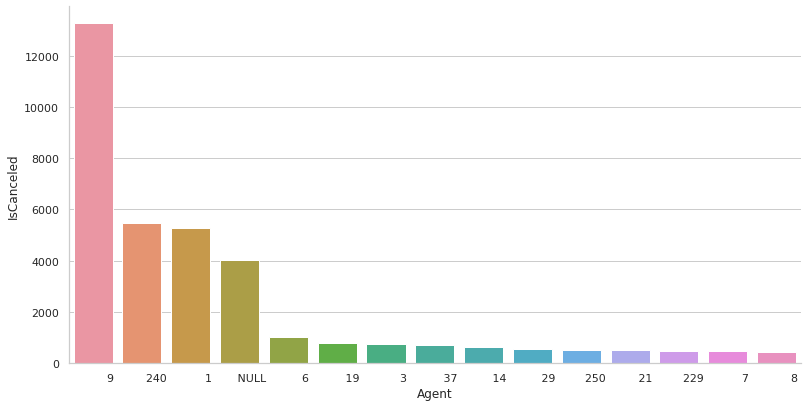

         IsCanceled
count     15.000000
mean    2330.200000
std     3518.634195
min      427.000000
25%      509.500000
50%      717.000000
75%     2527.500000
max    13264.000000


In [146]:
def many_levels_analysis(feature):
  print('values count')
  df=(df_analysis.groupby([feature]).count()['IsCanceled']
      .sort_values(ascending=False).head(15)).to_frame().reset_index()
  ax = sns.catplot(x=feature, y="IsCanceled", kind="bar", data=df)
  ax.fig.set_figwidth(14)
  ax.fig.set_figheight(6)
  plt.show()

  col_name = feature
  df=(df_analysis.groupby(['Hotel',col_name]).sum()['IsCanceled']/df_analysis.groupby(['Hotel',col_name]).count()['IsCanceled'] *100).to_frame()
  df.reset_index(inplace=True)

feature='Agent'
levels_analysis(feature)

Company

values count
       NULL    112593
         40       927
        223       784
         67       267
         45       250
                ...  
         18         1
        415         1
        531         1
        258         1
        101         1
Name: Company, Length: 353, dtype: int64


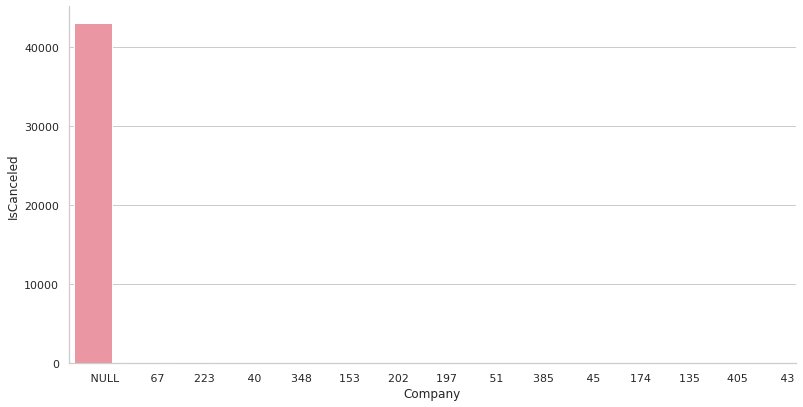

         IsCanceled
count     15.000000
mean    2916.866667
std    11097.879301
min       18.000000
25%       24.500000
50%       35.000000
75%       68.000000
max    43033.000000


In [101]:
feature='Company'
levels_analysis(feature)

ADR (Average daily rate)

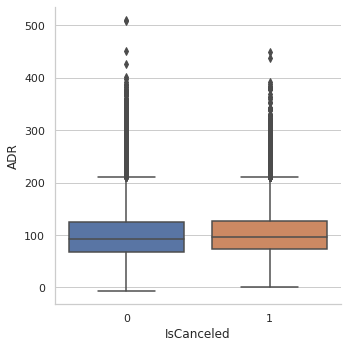

In [188]:
df=df_analysis[df_analysis['ADR']< 5000][['IsCanceled','ADR']]
#df.IsCanceled=df.IsCanceled.astype('str')
sns.catplot(x="IsCanceled", y="ADR", kind="box", data=df)

### Preprocessing

In [8]:
#Libraries

!pip install vtreat
import vtreat
import numpy as np

#Preprocessing
df_data=df_raw.copy()

# NAN
df_data.isnull().any() # nan found in Country & Children

df_data['ArrivalDateMonthNum']=df_data.ArrivalDateMonth.replace({ 'January' : 1, 'February' : 2, 'March' : 3, 'April' :4, 'May': 5, 'June' : 6, 'July':7, 'August' : 8, 'September' : 9, 'October' : 10, 'November': 11, 'December' : 12 })
df_data.drop(columns='ArrivalDateMonth',inplace=True)

# the value of the country is unreliable
# country is deleted
df_data.drop(columns = 'Country', inplace = True)

# Deleting last booking change
df_data.drop(columns = 'ReservationStatusDate', inplace = True)

# nan in Children are replaced by 0
df_data.Children.replace(np.nan, 0,inplace = True)

# Agent
# replace NULL by 0
df_data.Agent.replace({'       NULL':0},inplace = True)
df_data.Agent.nunique() #334 unique values

# Company
# replace NULL by 0
df_data.Company.replace({'       NULL':0},inplace = True)
# df_data.Company=df_data.Company.astype('int')

df_data.Company.nunique() #353 unique values

# Using vtreat for Agent & Company
df_vtreat=[]
df_vtreat =pd.concat([df_data[['IsCanceled']],df_data[['Company','Agent']]], axis=1)

transform = vtreat.BinomialOutcomeTreatment(
outcome_name='IsCanceled',    # outcome variable
outcome_target=True)  # outcome of interest

d_prepared = transform.fit_transform(df_vtreat, df_vtreat['IsCanceled'])
transform.score_frame_

df_data.drop(columns = ['Agent','Company'], inplace = True)

df_pdata=[] #df processed data -> pdata
df_pdata = pd.concat([df_data,d_prepared.loc[:, d_prepared.columns != 'IsCanceled']], axis=1)

X=[]
Y=[]
Z=[]

X=df_data.loc[:, df_data.columns != 'IsCanceled'] #Features
Y=df_data['IsCanceled'] #Outcome
Z=df_pdata.copy() #all data
df_data.head()

,IsCanceled,Company_logit_code,Company_prevalence_code,Company_lev_0,Agent_logit_code,Agent_prevalence_code,Agent_lev_ 9,Agent_lev_0,Agent_lev_ 240
0,0,0.030871,0.943069,1.0,-0.406209,0.136862,0.0,1.0,0.0
1,0,0.030624,0.943069,1.0,-0.405164,0.136862,0.0,1.0,0.0
2,0,0.030624,0.943069,1.0,-0.405164,0.136862,0.0,1.0,0.0
3,0,0.030624,0.943069,1.0,0.000000,0.000008,0.0,0.0,0.0
4,0,0.032507,0.943069,1.0,0.059447,0.116609,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
119385,0,0.032507,0.943069,1.0,-1.886552,0.000276,0.0,0.0,0.0
119386,0,0.030624,0.943069,1.0,0.105332,0.267702,1.0,0.0,0.0
119387,0,0.031162,0.943069,1.0,0.113992,0.267702,1.0,0.0,0.0
119388,0,0.032507,0.943069,1.0,-1.934605,0.000829,0.0,0.0,0.0


### Logistic Regresion

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Metrics function

def clf_metrics(X,y,model):
  y_pred = pd.Series(model.predict(X))
  y_prob= model.predict_proba(X) 
    
  # Accuracy  
  print('Accuracy =',str(metrics.accuracy_score(y,y_pred)))
        
  # AUC
  fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  print('AUC = %0.2f' % roc_auc)
        
  # Logloss
  Logloss = metrics.log_loss(y, y_prob[:,1])
  print('LogLoss = %0.2f' % Logloss)

  # F1-score
  F1_score = metrics.f1_score(y, y_pred)
  print('F1_score = %0.2f' % Logloss)

  # Mathews correlation      
  matthews_corr = metrics.matthews_corrcoef(y, y_pred)
  print('Matthews_corr = %0.2f' % matthews_corr)
  #return y_pred,y_prob

# Lead Time

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
y_train= y_train.to_numpy().ravel()

feature = 'LeadTime'

print('feature :',feature)

clf = LogisticRegression(random_state=0, solver='lbfgs')
clf=clf.fit(x_train[[feature]],y_train)
y_pred = clf.predict(x_train[[feature]])

print('coefficient:',clf.coef_)
print('intercept:',clf.intercept_)

y_pred.shape
clf_metrics(x_train[[feature]],y_train,clf)
print('\n Confusion matrix')
pd.crosstab(y_pred, y_train, rownames=['Actual'], colnames=['Predicted'])



feature : LeadTime
coefficient: [[0.0058354]]
intercept: [-1.16668895]
Accuracy = 0.6612502442974006
AUC = 0.69
LogLoss = 0.62
F1_score = 0.62
Matthews_corr = 0.21

 Confusion matrix


Predicted,0,1
Actual,,
0,60064,28725
1,7674,10988


### SVM (Support vector machine)

### XGboost

 “Extreme Gradient Boosting” is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. 

In [0]:
### Function
### XG Boosting with stratified CV and GridSearch

def XGBC_Boss(X,Y,params):
    
  # time 
  _start_time = time.time()
    
  tic()
  
  # Splitting train and test
  
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)   
  y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  y_test = y_test.to_numpy().ravel()    
    
  # Model
    
  xgbmodel=XGBClassifier()
     
  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'

  kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)
  grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                     param_grid = params, # param_grid
                     scoring = scoring,
                     cv = kfold,
                     n_jobs=3, 
                     refit = refit,
                     verbose = 2)
    
  model_result_xgboost = grid_solver.fit(x_train,y_train)
    
  print('Best parameters: ',model_result_xgboost.best_estimator_)

  # return predictions
  Y_pred = pd.Series(model_result_xgboost.predict(x_train))
  Y_prob= model_result_xgboost.predict_proba(x_train)
    
  # Metrics

  print('***** RESULTS ***** \n***** TRAIN *****')
  clf_metrics(x_train,y_train,model_result_xgboost)
        
  print('***** TEST *****')
  clf_metrics(x_test,y_test,model_result_xgboost)
    
  print('***** ALL DATA *****')
  Y_pd = pd.DataFrame(Y_array)
  y_pred,y_prob=clf_metrics(X,Y,model_result_xgboost)

  tac() # time elapsed
      
  return Y_pred,Y_prob,model_result_xgboost

# parameters

params={'base_score': [0.8], 
         'booster': ['gbtree'],
         'colsample_bylevel': [1], 
         'colsample_bytree': [0.8], 
         'gamma': [0.01],
         'learning_rate': [0.01], 
         'max_depth': [6],
         'min_child_weight': [1],
         'missing': [None],
         'n_estimators': [400],
         'n_jobs': [-1], 
         'objective': ['binary:logistic'],
         'random_state': [15], 
         'reg_alpha': [0.01], 
         'reg_lambda': [0.01],
         'scale_pos_weight': [1],
         'subsample': [0.9]}  

Y_pred,Y_prob,model_result_xgboost=XGBC_Boss(X,Y,params)

Fitting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


ValueError: ignored

Results

>Split | Accuracy |  AUC |  Logloss
>--- | --- | --- | ---
>TRAIN | 0.82902 | 0,90 | 0,37
>TEST | 0.82988 | 0,90 | 0,37
>ALL | 0.82911 | 0,90 | 0,37

Features used in the model

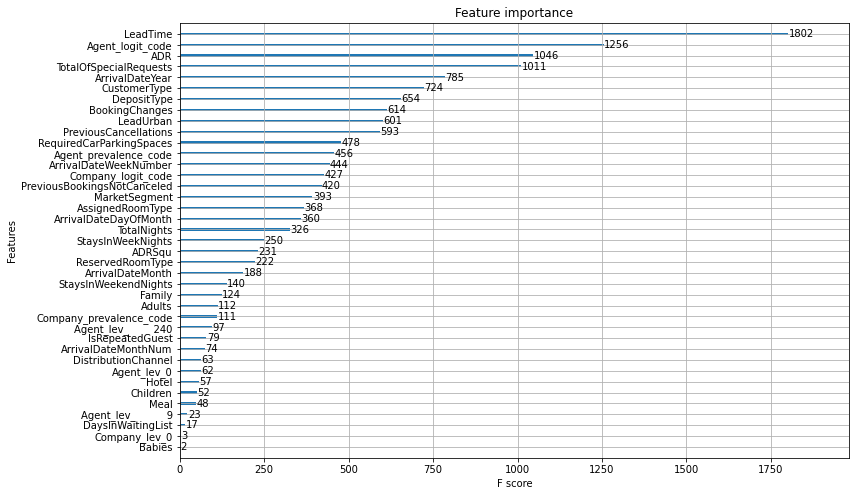

In [0]:
#xgbm=model_result_xgboost.best_estimator_

# Plot importance
#fig, ax = plt.subplots(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model_result_xgboost.best_estimator_,ax=ax)

### LightGBM

In [0]:
### Function
### LightGBM using stratified cross validation and GridSearch

def light_LGBM(X,y,param_grid):
    
  _start_time = time.time()
  tic()
     
  indexes_of_categories=[]
    
  lbl = preprocessing.LabelEncoder()
    
  for i in range(X.shape[1]):
      if X.dtypes[i]=='object':
          indexes_of_categories.append(i)
          lbl.fit(X.iloc[:,i])
          X.iloc[:,i]=lbl.transform(X.iloc[:,i])
        
  # Splitting
           
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)    
  y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  y_test = y_test.to_numpy().ravel()         
          
  Kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)          
  gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
     
  lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary') 

  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'
     
  gsearch = GridSearchCV(estimator=lgb_estimator, 
                         param_grid=param_grid, 
                         cv=gkf,scoring=scoring,
                         refit=refit,
                         verbose = 2)
    
  lgb_model = gsearch.fit(X=X_train, y=y_train)
    
  print('Results ********** ')
      
  print('Best parameters:',str(lgb_model.best_params_))
   
  print('********** TRAIN ********** ')
  clf_metrics(X_train,y_train,lgb_model)
        
  print('********** TEST ********** ')
  clf_metrics(X_test,y_test,lgb_model)
    
  print('********** ALL DATA ********** ')
  y_pred,y_prob=clf_metrics(X,y,lgb_model)
     
  # Plot importance PENDING
  # fig, ax = plt.subplots(figsize=(20, 15))
    
  # lgb.plot_importance(lgb_estimator,ax=ax)
  # lgb.plot_importance(gsearch.Booster,ax=ax)
  # lgb.plot_importance(lgb_model.Booster_Booster,ax=ax)
  # lgb.plot_importance(lgb_model,ax=ax)
    
  # plot_tree(lgb_model._Booster)
    
    
  # lgb_model.plot_importance()
  # # fig = plot_imp.figure
  # # fig.set_size_inches(5, 10)
  # plt.savefig('lightLGBM.png')
         
  # time
  tac()
    
  return y_pred,y_prob,


param_grid = {
'num_leaves': [31],
'learning_rate':[0.1],
'min_data_in_leaf': [30],
'lambda_l1': [0],
'lambda_l2': [0],
'max_depth': [3],
}  

y_pred,y_prob = light_LGBM(X,Y,param_grid)

Fitting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.6s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 
[CV]  lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31, total=   1.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


Results ********** 
Best parameters: {'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 30, 'num_leaves': 31}
********** TRAIN ********** 
Accuracy = 0.8264418199923687
AUC = 0.90
LogLoss = 0.37
********** TEST ********** 
Accuracy = 0.829047658932909
AUC = 0.90
LogLoss = 0.37
********** ALL DATA ********** 
Accuracy = 0.8267024038864227
AUC = 0.90
LogLoss = 0.37
Time passed: 0hour:0min:11sec


### Neural network